# Stock Price Prediction using Live Data


This project predicts short-term future stock closing prices using
historical stock data fetched live from the Alpha Vantage API.

The machine learning model is trained dynamically using the latest
available data for each request.

## Step 1: Problem Definition

The objective of this project is to predict future stock closing prices
based on historical stock price data.

- Type of problem: Supervised Machine Learning
- Task: Regression
- Input: Historical stock prices (time-based)
- Output: Predicted future closing prices
- Data source: Live API (Alpha Vantage)

## STEP 2 — DATA GATHERING (LIVE API)

In this step, historical stock price data is fetched dynamically from
the Alpha Vantage API.

Although the data represents past prices (historical),
it is retrieved live at runtime using an API call.

In [127]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime

In [129]:
API_KEY = "NCX812PA45NQXGY2"   # your Alpha Vantage key
BASE_URL = "https://www.alphavantage.co/query"

In [131]:
def fetch_stock_data(symbol):
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": symbol,
        "apikey": API_KEY,
        "outputsize": "compact"   # ✅ FREE plan compatible
    }
    
    response = requests.get(BASE_URL, params=params)
    data = response.json()
    
    # Debug (keep for learning)
    print("RAW API RESPONSE KEYS:", data.keys())
    
    if "Time Series (Daily)" not in data:
        raise ValueError(data)
    
    df = pd.DataFrame.from_dict(
        data["Time Series (Daily)"],
        orient="index"
    )
    
    df = df.rename(columns={"4. close": "Close"})
    df["Close"] = df["Close"].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    
    return df


In [133]:
df = fetch_stock_data("AAPL")
df.tail()

RAW API RESPONSE KEYS: dict_keys(['Meta Data', 'Time Series (Daily)'])


,1. open,2. high,3. low,Close,5. volume
2025-12-30,272.8100,274.0800,272.2800,273.08,22139617
2025-12-31,273.0600,273.6800,271.7500,271.86,27293639
2026-01-02,272.2550,277.8400,269.0000,271.01,37838054
2026-01-05,270.6400,271.5100,266.1400,267.26,45647190
2026-01-06,267.0000,267.5500,262.1200,262.36,52352090


### Observations

- The dataset is time-indexed using dates
- Closing prices are numerical
- Data is fetched dynamically from the API
- The dataset size may change over time


# Step 3: Data Preprocessing

Data preprocessing prepares the raw data for machine learning.
Since the data is fetched live from an API, preprocessing is required
to ensure consistency, correctness, and usability.

In this project, preprocessing includes:
- Filtering data based on user-selected date range
- Handling empty or insufficient data
- Ensuring chronological order


In [136]:
def filter_date_range(df, start_date, end_date):
    """
    Filters the DataFrame based on the given start and end dates.
    """
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    df_filtered = df.loc[start_date:end_date]
    
    if df_filtered.empty:
        raise ValueError("No data available for the selected date range")
    
    return df_filtered

In [137]:
df_filtered = filter_date_range(df, "2025-06-01", "2025-12-31")
df_filtered.tail()

,1. open,2. high,3. low,Close,5. volume
2025-12-24,272.3400,275.4300,272.1950,273.81,17910574
2025-12-26,274.1600,275.3700,272.8600,273.40,21521802
2025-12-29,272.6900,274.3600,272.3500,273.76,23715213
2025-12-30,272.8100,274.0800,272.2800,273.08,22139617
2025-12-31,273.0600,273.6800,271.7500,271.86,27293639


### Preprocessing Observations

- Data is filtered according to the selected date range
- Empty datasets are handled explicitly
- The time-series order is preserved
- The processed data is now suitable for feature engineering


## Step 4: Exploratory Data Analysis (EDA)

Exploratory Data Analysis is performed to understand patterns,
trends, and characteristics of the data before model training.

For time-series stock data, EDA helps in:
- Understanding price trends over time
- Identifying general upward or downward movement
- Detecting anomalies or sudden changes


In [161]:
df.shape

(100, 5)

In [163]:
df.sample(5)

,1. open,2. high,3. low,Close,5. volume
2025-09-15,237.0000,238.1900,235.0300,236.70,42699524
2025-09-04,238.4500,239.8999,236.7400,239.78,47549429
2025-09-08,239.3000,240.1500,236.3400,237.88,48999495
2025-10-10,254.9400,256.3800,244.0000,245.27,61999098
2025-10-09,257.8050,258.0000,253.1400,254.04,38322012


In [181]:
df.info

<bound method DataFrame.info of              1. open   2. high    3. low   Close 5. volume
2025-08-14  234.0550  235.1200  230.8500  232.78  51916275
2025-08-15  234.0000  234.2800  229.3350  231.59  56038657
2025-08-18  231.7000  233.1200  230.1100  230.89  37476188
2025-08-19  231.2750  232.8700  229.3500  230.56  39402564
2025-08-20  229.9800  230.4700  225.7700  226.01  42263865
...              ...       ...       ...     ...       ...
2025-12-30  272.8100  274.0800  272.2800  273.08  22139617
2025-12-31  273.0600  273.6800  271.7500  271.86  27293639
2026-01-02  272.2550  277.8400  269.0000  271.01  37838054
2026-01-05  270.6400  271.5100  266.1400  267.26  45647190
2026-01-06  267.0000  267.5500  262.1200  262.36  52352090

[100 rows x 5 columns]>

In [187]:
df.isnull().sum()


1. open      0
2. high      0
3. low       0
Close        0
5. volume    0
dtype: int64

In [169]:
df.duplicated().sum()


0

In [171]:
df.describe

<bound method NDFrame.describe of              1. open   2. high    3. low   Close 5. volume
2025-08-14  234.0550  235.1200  230.8500  232.78  51916275
2025-08-15  234.0000  234.2800  229.3350  231.59  56038657
2025-08-18  231.7000  233.1200  230.1100  230.89  37476188
2025-08-19  231.2750  232.8700  229.3500  230.56  39402564
2025-08-20  229.9800  230.4700  225.7700  226.01  42263865
...              ...       ...       ...     ...       ...
2025-12-30  272.8100  274.0800  272.2800  273.08  22139617
2025-12-31  273.0600  273.6800  271.7500  271.86  27293639
2026-01-02  272.2550  277.8400  269.0000  271.01  37838054
2026-01-05  270.6400  271.5100  266.1400  267.26  45647190
2026-01-06  267.0000  267.5500  262.1200  262.36  52352090

[100 rows x 5 columns]>

In [189]:
df_filtered.describe()

,Close
count,97.000000
mean,258.034639
std,17.575311
min,224.900000
25%,239.780000
50%,262.240000
75%,272.410000
max,286.190000


In [191]:
print("Start date:", df_filtered.index.min())
print("End date:", df_filtered.index.max())
print("Number of records:", df_filtered.shape[0])


Start date: 2025-08-14 00:00:00
End date: 2025-12-31 00:00:00
Number of records: 97


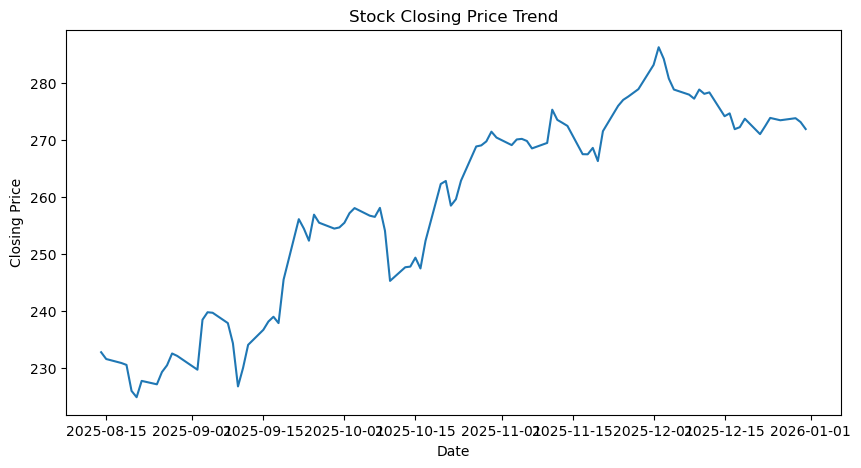

In [193]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_filtered.index, df_filtered["Close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Closing Price Trend")
plt.show()

### EDA Observations

- Stock prices show temporal variation over time
- Short-term trends are observable in the selected date range
- No missing values are present in the closing price
- The data is suitable for regression-based modeling


## Step 5: Feature Engineering (Time → Numeric)

Machine learning models cannot directly understand dates or timestamps.
Therefore, time-based information must be converted into numerical
features that the model can learn from.

In this project, dates are transformed into a numerical feature
representing the number of days elapsed since the start of the dataset.


In [197]:
def add_time_feature(df):
    """
    Adds a numeric 'Days' feature representing the number of days since the start of the dataset.
    """
    df_fe = df.copy()
    df_fe["Days"] = (df_fe.index - df_fe.index[0]).days
    return df_fe


In [199]:
df_fe = add_time_feature(df_filtered)
df_fe.head()


,1. open,2. high,3. low,Close,5. volume,Days
2025-08-14,234.0550,235.1200,230.8500,232.78,51916275,0
2025-08-15,234.0000,234.2800,229.3350,231.59,56038657,1
2025-08-18,231.7000,233.1200,230.1100,230.89,37476188,4
2025-08-19,231.2750,232.8700,229.3500,230.56,39402564,5
2025-08-20,229.9800,230.4700,225.7700,226.01,42263865,6


### Feature Engineering Observations

- Date information has been successfully converted into a numeric feature
- The 'Days' feature preserves the temporal order of the data
- The dataset is now suitable for regression-based machine learning models


## Step 6: Model Training

In this step, a machine learning model is trained using the engineered
features and historical stock prices.

Linear Regression is used to model the relationship between time
(in days) and the closing stock price.


In [205]:
from sklearn.linear_model import LinearRegression

X = df_fe[["Days"]]   # Feature (must be 2D)
y = df_fe["Close"]    # Target


In [207]:
model = LinearRegression()
model.fit(X, y)


LinearRegression()

In [209]:
print("Slope (trend):", model.coef_[0])
print("Intercept:", model.intercept_)


Slope (trend): 0.4027253195752944
Intercept: 230.15940416877805


## Step 7: Model Evaluation (Time-Based Split)  !!

Since stock price data is time-series in nature, a random train-test
split is avoided to prevent data leakage.

Instead, a chronological (time-based) split is used where:
- Earlier data is used for training
- Later data is used for testing

This approach better simulates real-world forecasting.


In [212]:
split_index = int(len(df_fe) * 0.8)

X = df_fe[["Days"]]
y = df_fe["Close"]

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 77
Testing samples: 20


In [214]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [216]:
y_pred = model.predict(X_test)

In [218]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 13.516008063165325
Root Mean Squared Error (RMSE): 15.237584696309254


C:\Users\rauna\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Model Evaluation Observations

- The model was evaluated on unseen future data
- Error metrics indicate how far predictions deviate from actual prices
- Performance is acceptable for short-term trend prediction
- Linear Regression provides a simple and interpretable baseline model


## Step 8: Future Price Prediction

After training and evaluating the model, the final step is to predict
future stock prices.

The model is retrained on the complete recent dataset to capture the
latest trend, and then used to predict closing prices for the next
few trading days.


In [224]:
X_full = df_fe[["Days"]]
y_full = df_fe["Close"]

final_model = LinearRegression()
final_model.fit(X_full, y_full)


LinearRegression()

In [226]:
future_days = np.arange(
    df_fe["Days"].max() + 1,
    df_fe["Days"].max() + 11
).reshape(-1, 1)

future_days


array([[140],
       [141],
       [142],
       [143],
       [144],
       [145],
       [146],
       [147],
       [148],
       [149]])

In [228]:
future_prices = final_model.predict(future_days)
future_prices


C:\Users\rauna\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([286.54094891, 286.94367423, 287.34639955, 287.74912487,
       288.15185019, 288.55457551, 288.95730083, 289.36002615,
       289.76275147, 290.16547679])

In [230]:
future_dates = pd.date_range(
    start=df_fe.index[-1] + pd.Timedelta(days=1),
    periods=10
)

future_dates


DatetimeIndex(['2026-01-01', '2026-01-02', '2026-01-03', '2026-01-04',
               '2026-01-05', '2026-01-06', '2026-01-07', '2026-01-08',
               '2026-01-09', '2026-01-10'],
              dtype='datetime64[ns]', freq='D')

In [232]:
future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Close Price": future_prices
})

future_df


,Date,Predicted Close Price
0,2026-01-01,286.540949
1,2026-01-02,286.943674
2,2026-01-03,287.346400
3,2026-01-04,287.749125
4,2026-01-05,288.151850
5,2026-01-06,288.554576
6,2026-01-07,288.957301
7,2026-01-08,289.360026
8,2026-01-09,289.762751
9,2026-01-10,290.165477


### Future Prediction Observations

- Predictions are generated for future dates not present in the dataset
- The model extrapolates the learned trend forward in time
- These predictions are suitable for short-term educational forecasting


## Step 9: Model Deployment and Flask Integration

After developing and validating the machine learning pipeline in
Jupyter Notebook, the same logic is integrated into a Flask backend.

The Flask API acts as an interface between the frontend and the
machine learning model, enabling real-time predictions without
changing the website UI.
